In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [4]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd
    
def get_time_df(df, global_average, global_sd):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_df(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """

    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
#     global_average = float(gb.mean())
#     global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [5]:
def get_grade_dev_df(df):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dev_df(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']

    return gb


In [6]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [7]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [8]:
df = get_clean_cape_dataframe('data_clean.csv')

In [9]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [10]:
user_input = input("Enter ratings separated by spaces: ")
ratings = list(map(int, user_input.split()))

def weights(ratings):
    '''
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    
    '''
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 5 5 5


In [11]:
weights = weights(ratings)
print(weights)

[0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [67]:
# Check if the quarter is valid
input_quarters = input("Enter quarter numbers separated by spaces: ").split()
for input_quarter in input_quarters:
    assert input_quarter.isnumeric(), 'Input is not numeric'
    assert int(input_quarter) < 6 and int(input_quarter) > 0, 'Quarters are out of range'
    
quarters = list(map(int, input_quarters))

print(quarters)

Enter quarter numbers separated by spaces: 1
[1]


## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [51]:
# create a dictionary of all departments and courses
all_depts_dict = get_depts_and_courses_dictionary(df)

user_input = input("Enter department names separated by spaces: ")

depts_input = user_input.split()
depts = []
for dept in depts_input:
    dept = dept.upper()
    assert dept in all_depts_dict, 'The input is not a valid department'
    depts.append(dept)

depts

Enter department names separated by spaces: cse ece 


['CSE', 'ECE']

In [15]:
# Map the quarter to the integer
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",WI23,65,46,93.5,93.3,4.15,AAS 11,Intro Black Diasporic Studies (A),A-,3.84,A-,3.71
1,"Shtienberg, Gilad",WI23,27,9,100.0,100.0,3.61,ANAR 116,Sea Level ChangeIsrael (A),A,4.00,B+,3.62
2,"Braswell, Geoffrey E.",WI23,24,15,100.0,92.9,3.42,ANAR 135,Ancient Mediterranean Civ (A),A,4.00,A-,3.99
3,"Rodriguez, Eric Andrew",WI23,41,23,100.0,100.0,4.07,ANAR 164,Underwater Archaeology (A),A-,3.80,B+,3.63
4,"Non, Amy L",WI23,71,45,84.4,81.8,4.28,ANBI 130,Biology of Inequality (A),B+,3.42,B+,3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,"Cho, Erica",FA19,127,78,81.6,70.7,6.47,VIS 70N,Introduction to Media (A),B+,3.64,B+,3.59
8436,"Tonies, Joshua Vanjaymes",FA19,115,96,97.9,98.9,9.43,VIS 80,Introduction to Studio Major (A),B+,3.67,B+,3.65
8437,"McCleary, Keith Long",FA19,20,20,95.0,100.0,8.70,WCWP 100,Academic Writing (B),B,3.00,B,3.28
8438,"Gagnon, Jeffrey C",FA19,697,398,74.3,86.9,4.77,WCWP 10A,The Writing Course A (0),B+,3.39,B,3.28


In [16]:
# Slice the dataframe and only keep the desired department
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
216,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
217,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
218,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58


In [17]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['inv_time'] = -1 * df_quarter['time']
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['inv_time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['inv_time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75,-8.09,-0.49,18.409091,28.636364,59.090909,56.818182,9.545455
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04,-8.31,-0.04,37.045455,70.227273,66.818182,50.681818,62.500000
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89,-4.75,-0.19,27.954545,33.409091,16.818182,97.272727,41.363636
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06,-8.82,0.19,39.318182,9.090909,10.000000,41.363636,90.454545
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75,-7.07,-0.38,18.409091,16.818182,48.636364,77.727273,18.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-6.76,-0.14,85.000000,81.363636,70.000000,81.136364,48.181818
216,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-6.76,-0.14,85.000000,81.363636,90.909091,81.136364,48.181818
217,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-6.76,-0.14,85.000000,81.363636,77.727273,81.136364,48.181818
218,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-6.76,-0.14,85.000000,81.363636,90.909091,81.136364,48.181818


In [18]:
# generate the ranking based on weights
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,...,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score,rec_score_percentile
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,...,2.75,-8.09,-0.49,18.409091,28.636364,59.090909,56.818182,9.545455,35.389610,25.909091
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,...,3.04,-8.31,-0.04,37.045455,70.227273,66.818182,50.681818,62.500000,53.571429,58.181818
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,...,2.89,-4.75,-0.19,27.954545,33.409091,16.818182,97.272727,41.363636,48.863636,50.909091
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,...,3.06,-8.82,0.19,39.318182,9.090909,10.000000,41.363636,90.454545,38.701299,30.909091
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,...,2.75,-7.07,-0.38,18.409091,16.818182,48.636364,77.727273,18.636364,39.480519,32.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,...,3.58,-6.76,-0.14,85.000000,81.363636,70.000000,81.136364,48.181818,75.974026,86.363636
216,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,...,3.58,-6.76,-0.14,85.000000,81.363636,90.909091,81.136364,48.181818,78.961039,90.227273
217,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,...,3.58,-6.76,-0.14,85.000000,81.363636,77.727273,81.136364,48.181818,77.077922,87.727273
218,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,...,3.58,-6.76,-0.14,85.000000,81.363636,90.909091,81.136364,48.181818,78.961039,90.227273


In [19]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [20]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

,index,Course_ID,Course_Name,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score,rec_score_percentile
0,12,ECE 134,Electrnc Materls Sci/Integ Cir,24.00,11.50,100.00,100.00,5.86,3.47,3.56,-5.86,0.09,83.30,94.32,90.91,89.77,80.11,87.35,98.18
1,16,ECE 143,Programming for Data Analysis,102.75,71.25,96.28,97.22,7.61,3.86,3.88,-7.61,0.01,96.79,77.87,73.12,66.79,71.11,78.47,90.06
2,41,ECE 5,Intro to ECE,123.15,56.38,97.92,98.69,6.45,3.75,3.54,-6.45,-0.21,80.66,85.10,82.66,84.48,39.79,76.83,89.06
3,10,ECE 128A,Real Wrld Pwr Grid Operation,50.00,18.25,90.62,92.92,5.99,3.43,3.55,-5.99,0.11,80.00,62.10,62.16,84.60,79.43,76.13,85.11
4,11,ECE 128B,Power Grid Modernization,48.25,20.25,92.38,90.98,5.72,3.52,3.54,-5.72,0.01,78.41,66.93,60.68,88.47,70.91,76.04,83.18
5,25,ECE 161B,Digital Signal Processing I,40.25,15.75,96.68,100.00,7.96,3.18,3.24,-7.96,0.06,58.81,80.40,90.91,60.11,74.77,69.13,79.55
6,29,ECE 171A,Linear Control System Theory,48.00,21.00,97.75,100.00,9.22,3.48,3.52,-9.22,0.04,80.45,84.89,90.91,37.16,71.36,68.91,79.89
7,21,ECE 157A,Communications Systems Lab I,22.00,10.00,88.90,100.00,9.17,3.50,3.68,-9.17,0.18,90.45,48.64,90.91,35.00,89.77,68.60,81.36
8,13,ECE 135A,Semiconductor Physics,23.50,10.00,95.85,100.00,4.75,3.54,3.10,-4.75,-0.43,46.25,76.36,90.91,97.27,23.52,68.26,77.95
9,34,ECE 176,Intro Deep Learning & Apps,81.00,29.50,91.85,82.80,8.21,3.64,3.80,-8.21,0.17,95.11,64.43,26.93,54.09,81.82,67.37,76.70


In [21]:
# Presents data to user
result = df_group[['Course_ID', 'Course_Name']][0:5]

print('Based on your preferences, these are the top 5 classes we recommend for you: \n')
print(result)

Based on your preferences, these are the top 5 classes we recommend for you: 

  Course_ID                      Course_Name
0   ECE 134  Electrnc Materls Sci/Integ Cir 
1   ECE 143   Programming for Data Analysis 
2     ECE 5                    Intro to ECE 
3  ECE 128A    Real Wrld Pwr Grid Operation 
4  ECE 128B        Power Grid Modernization 


In [22]:
# factor 1: Time spent
global_average, global_std = get_global_avg_time(df2)
time_factor = get_time_df(df_quarter, global_average, global_std)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(time_factor_depart)

   Course_ID   time  depart_avg_time  global_avg_time  depart_time_diff  \
0    ECE 100   9.18             8.67         5.800227              0.51   
1    ECE 101   8.54             8.67         5.800227             -0.13   
2    ECE 102   8.52             8.67         5.800227             -0.15   
3    ECE 103   6.14             8.67         5.800227             -2.53   
4    ECE 107   7.84             8.67         5.800227             -0.83   
5    ECE 109   7.40             8.67         5.800227             -1.27   
6    ECE 111   7.17             8.67         5.800227             -1.50   
7   ECE 121A   8.90             8.67         5.800227              0.23   
8   ECE 121B   9.05             8.67         5.800227              0.38   
9   ECE 125A   8.67             8.67         5.800227              0.00   
10  ECE 128A   5.99             8.67         5.800227             -2.68   
11  ECE 128B   5.72             8.67         5.800227             -2.95   
12   ECE 134   5.86      

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_7028/3903882608.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_7028/3903882608.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_7028/3903882608.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

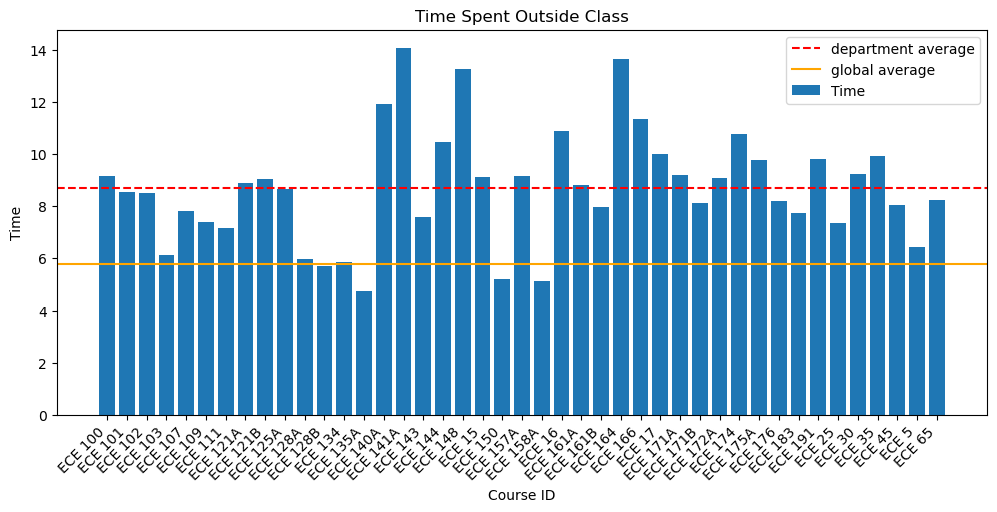

In [69]:
time_draw = time_factor_depart 

plt.figure(figsize=(12, 5))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='department average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='global average')

plt.title('Time Spent Outside Class')
plt.xlabel('Course ID')
plt.ylabel('Time')

plt.xticks(rotation=45, ha='right')

plt.legend()
plt.show()

In [24]:
# factor 2: difference between actual gpa and expected gpa
grade_dev_factor = get_grade_dev_df(df_quarter)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)

   Course_ID  expected_gpa  actual_gpa   dev
0    ECE 100          3.28        2.93 -0.35
1    ECE 101          3.13        2.96 -0.17
2    ECE 102          3.08        3.09  0.01
3    ECE 103          2.98        3.04  0.06
4    ECE 107          3.06        3.05 -0.01
5    ECE 109          2.99        2.78 -0.21
6    ECE 111          3.52        3.56  0.04
7   ECE 121A          3.15        3.13 -0.02
8   ECE 121B          3.27        3.18 -0.09
9   ECE 125A          3.18        3.06 -0.12
10  ECE 128A          3.43        3.55  0.12
11  ECE 128B          3.52        3.54  0.02
12   ECE 134          3.47        3.56  0.09
13  ECE 135A          3.54        3.10 -0.44
14  ECE 140A          3.57        3.36 -0.21
15  ECE 141A          3.45        2.88 -0.57
16   ECE 143          3.86        3.88  0.02
17   ECE 144          3.47        3.60  0.13
18   ECE 148          3.68        3.90  0.22
19    ECE 15          3.15        2.79 -0.36
20   ECE 150          3.78        3.46 -0.32
21  ECE 15

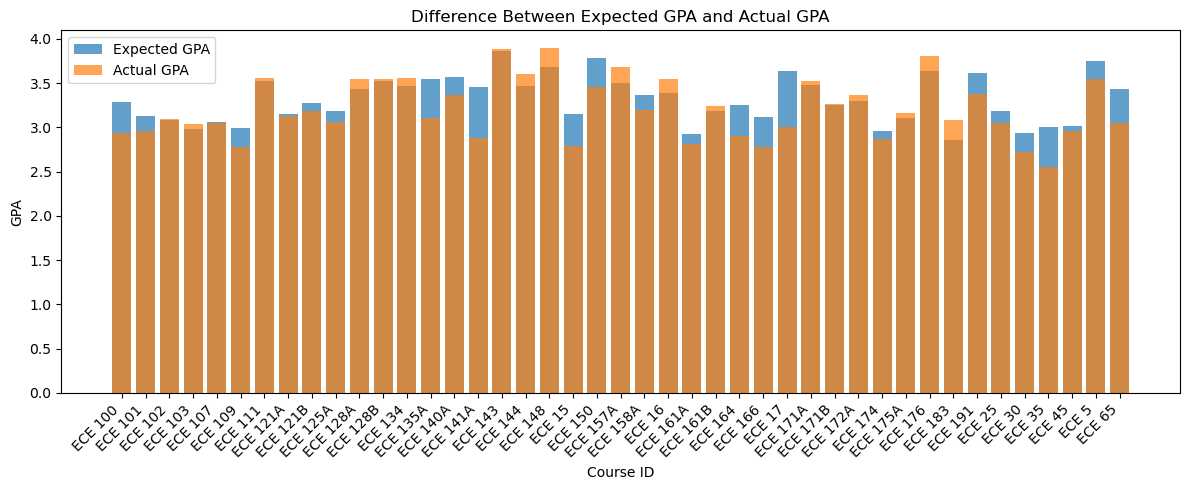

In [71]:
grade_dev_draw = grade_dev_factor_depart  

plt.figure(figsize=(12, 5))

plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['expected_gpa'], label='Expected GPA', alpha=0.7)
plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['actual_gpa'], label='Actual GPA', alpha=0.7)


plt.title('Difference Between Expected GPA and Actual GPA')
plt.xlabel('Course ID')
plt.ylabel('GPA')


plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['actual_gpa']].copy()
print(grade_factor_depart)

    actual_gpa
0         2.93
1         2.96
2         3.09
3         3.04
4         3.05
5         2.78
6         3.56
7         3.13
8         3.18
9         3.06
10        3.55
11        3.54
12        3.56
13        3.10
14        3.36
15        2.88
16        3.88
17        3.60
18        3.90
19        2.79
20        3.46
21        3.68
22        3.19
23        3.54
24        2.81
25        3.24
26        2.90
27        2.78
28        3.00
29        3.52
30        3.26
31        3.36
32        2.87
33        3.16
34        3.80
35        3.08
36        3.38
37        3.05
38        2.72
39        2.55
40        2.96
41        3.54
42        3.05


In [27]:
# gpa plot will not be plotted since it is included in the gpa difference figure. We simply add it as a weight for our recommendation system

In [28]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(class_factor_depart)

   Course_ID  rmd_class
0    ECE 100      88.50
1    ECE 101      85.90
2    ECE 102      95.08
3    ECE 103      74.27
4    ECE 107      74.06
5    ECE 109      74.91
6    ECE 111      82.44
7   ECE 121A      92.20
8   ECE 121B      90.48
9   ECE 125A      96.10
10  ECE 128A      90.62
11  ECE 128B      92.38
12   ECE 134     100.00
13  ECE 135A      95.85
14  ECE 140A      81.10
15  ECE 141A      81.35
16   ECE 143      96.28
17   ECE 144      95.24
18   ECE 148      85.15
19    ECE 15      80.86
20   ECE 150      89.85
21  ECE 157A      88.90
22  ECE 158A      90.10
23    ECE 16      93.42
24  ECE 161A      80.58
25  ECE 161B      96.68
26   ECE 164      92.08
27   ECE 166      93.28
28    ECE 17      89.80
29  ECE 171A      97.75
30  ECE 171B      93.72
31  ECE 172A      83.10
32   ECE 174      83.70
33  ECE 175A      79.75
34   ECE 176      91.85
35   ECE 183      75.00
36   ECE 191      86.10
37    ECE 25      85.48
38    ECE 30      65.28
39    ECE 35      86.11
40    ECE 45    

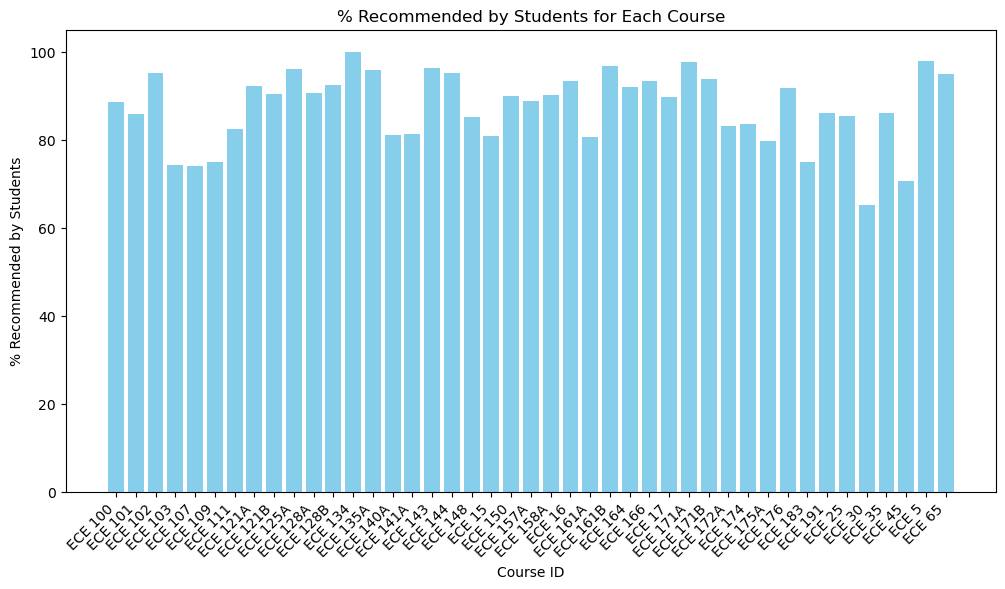

In [73]:
plt.figure(figsize=(12, 6))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'], color='skyblue')

plt.xlabel('Course ID')
plt.ylabel('% Recommended by Students')
plt.title('% Recommended by Students for Each Course')

plt.xticks(rotation=45, ha='right')

plt.show()

In [30]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(instr_factor_depart)

   Course_ID                    instr  rmd_instr
0    ECE 100     Baghdadchi, Saharnaz      95.70
1    ECE 100           Saad, Andrew S      60.50
2    ECE 100   Sievenpiper, Daniel F.      86.23
3    ECE 101     Baghdadchi, Saharnaz      97.63
4    ECE 101          Siegel, Paul H.      95.28
..       ...                      ...        ...
76     ECE 5            Gilja, Vikash      99.67
77     ECE 5            Hall, Drew A.      99.20
78     ECE 5  Morris, Karcher William      97.74
79     ECE 5     Nguyen, Truong Quang     100.00
80    ECE 65     Baghdadchi, Saharnaz      97.85

[81 rows x 3 columns]


## Check if a specific class is recommended or not

Type the class you are interested in and we will let you know the best professors and if we recommend it or not

Ex. ECE 143


In [81]:
class_in = input("Type you desired class:")

selected_depts_dict =
class_in_dept, class_in_num = class_in.split()
class_in_dept = class_in_dept.upper()

assert class_in_dept in all_depts_dict, 'The input is not a valid department'
assert class_in_num in all_depts_dict[class_in_dept], 'Course id is not valid for the department'

class_in_dept + ' ' + class_in_num 

Type you desired class:cse 133


AssertionError: Course id is not valid for the department

In [79]:
# Creates dataframe of entries for input class id and sorts by rec_score

df_class = df_quarter[df_quarter['Course_ID'].str.contains(class_in)]
df_class_grouped = df_class.groupby('instr').mean().round(2).reset_index()
df_class_grouped = df_class_grouped.sort_values(by = 'rec_score', ascending = False).reset_index()
df_class_grouped

,index,instr,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score,rec_score_percentile


In [ ]:
# Presents data to user
result_2 = df_class_grouped[['instr']]

print('Based on your preferences, these are the professors ranked for ' + str(class_in)+ ': \n')
print(result_2)

In [ ]:
rmd_score = df_group[df_group['Course_ID'].str.contains(class_in)]['rec_score']
num_score = rmd_score.values[0]

if num_score > 75:
    print('We strongly recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
elif num_score > 50:
    print('We recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
elif num_score > 25:
    print('We do not recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
else:
    print('We strongly do not recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")


False
